In [60]:
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

from matplotlib import pyplot as plt

In [3]:
!python -V
print(sklearn.__version__)
print(np.__version__)

Python 3.11.7
1.6.1
2.1.2


In [4]:
## 100k - 32 bit challenge responses 
data = np.loadtxt("APUF_CRP.txt")
data.shape

(100000, 33)

### preprocessing

> Using inappropriate features will render the linear model useless
- For example try the following features
    - Original 0/1 challenge vectors:
        - return X
    - Signed 0/1 challenge vectors:
        - return 1 - 2 * X
    - Forward cumulative product on signed challenge vectors:
        - return np.cumprod( np.flip( 1 - 2 * X, axis = 1 ), axis = 1 )

In [63]:
def Features(data):
    X = data[ :, :-1 ]
    y = data[:, -1]
    return X, y

def idFeatures( data ):
    ## get challenges 32bit
    X = data[ :, :-1 ]
    ## get response and flip binary (0,1 -> -1, 1 v 1, -1) not to necessary but helps. why ??
    y = np.where( data[ :, -1 ] > 0, -1, 1 )
    return X, y

def PUFFeatures( data ):
    X = data[ :, :-1 ]
    X = np.cumprod( np.flip( 1 - 2 * X, axis = 1 ), axis = 1 )
    y = np.where( data[ :, -1 ] > 0, -1, 1 )
    return X, y

In [39]:
train, test = train_test_split(data, train_size= 100)
print(f'train {train.shape}, test {test.shape}')

train (100, 33), test (99900, 33)


### using sklearn
`Support vector classifier`
<br>

[sklearn.linearsvc](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
- ```
    LinearSVC(
    penalty='l2',
    loss='squared_hinge',
    *,
    dual='auto',
    tol=0.0001,
    C=1.0,
    multi_class='ovr',
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    verbose=0,
    random_state=None,
    max_iter=1000,
    )
  ```

> Use more data and perfect regularization

In [66]:
### model with Features

clf_ = LinearSVC(loss = "hinge", C = 1000, verbose=True)
X_train, y_train = Features(train)
X_test, y_test = Features(test)
clf_.fit(X_train, y_train)

[LibLinear]....................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -4589.407851
nSV = 86


/home/rj/.pyenv/versions/3.11.7/envs/autobots/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, loss='hinge', verbose=True)

In [42]:
### model with idFeatures
clf = LinearSVC(loss = "hinge", C = 1000, verbose=True)
X_tra, y_tra = idFeatures(train)
X_tst, y_tst = idFeatures(test)
clf.fit(X_tra, y_tra)

[LibLinear]....................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -4583.814291
nSV = 86


/home/rj/.pyenv/versions/3.11.7/envs/autobots/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, loss='hinge', verbose=True)

In [43]:
clf_PUF = LinearSVC(loss = "hinge", C = 1000, verbose=True)
X_tra_PUF, y_tra_PUF = PUFFeatures(train)
X_tst_PUF, y_tst_PUF = PUFFeatures(test)
clf_PUF.fit(X_tra_PUF, y_tra_PUF)

[LibLinear]...........................*......................................*...............................***.**
optimization finished, #iter = 975
Objective value = -7.704142
nSV = 31


LinearSVC(C=1000, loss='hinge', verbose=True)

`Notes by purushot@iitk.ac.in`

- fit_intercept decides whether the model learnt will be of the form $\mathbf w^\top \mathbf x + b$ or $\mathbf w^\top \mathbf x$
 - C hyperparameter controls the urgency with which the SVM formulation tries to avoid misclassification and margin violations
 - tol controls how inaccurate a solution to the SVM formulation is acceptable to us
 - max_iter controls the upper limit on the number of iterations/epochs used by the solver

_Effect of various hyperparameters_
- Not having an intercept can result in mild to moderate decrease in accuracies
- Higher values of C can increase training time rapidly but also offer greater accuracies
- Higher values of tolerance will allow the solver to stop earlier decreasing training time but at the cost of possibly lower accuracies
- Note that the solver need not always carry out max_iter iterations/epochs. It may stop well before that if tolerance has been reached

_Overfitting_
- Excessively high values of C can lead to deceptively high training accuracy but poor test accuracy and increased training time
- The over phenomenon is called overfitting (where training accuracy is high but test accuracy low)
- Overfitting is more likely to happen if number of data points is limited e.g. try C = 1 vs C = 10 vs C = 1000 with just 1000 train points
- It is common to create a _mock test set_ often called a validation set, out of the training set to avoid overfitting\
data_t, data_tst = train_test_split( data, train_size = 1000 )\
data_trn, data_val = train_test_split( data_t, train_size = 800 )
- Hyperparameter values that acheive good performance on the validation set are chosen to train the final model over which testing is done
- Recall that test data must never be used during training

#### Evaluating models

In [69]:
##### features
w_, b_ = clf_.coef_, clf_.intercept_

# or w.reshape(-1) can be used
y_prediction = X_test@w_.T + b_
y_test_prediction = np.where( y_prediction > 0, 1, 0 )

y_prediction = X_train.dot( w_.T ) + b_
y_train_prediction = np.where( y_prediction > 0, 1, 0 )

In [71]:
test_accuracy = accuracy_score( y_test, y_test_prediction )
train_accuracy = accuracy_score(y_train, y_train_prediction)
print( "Test:", test_accuracy)
print( "Train:", train_accuracy )

Test: 0.48663663663663664
Train: 0.61


In [44]:
##### idfeatures
w, b = clf.coef_, clf.intercept_

# or w.reshape(-1) can be used
y_pred = X_tst@w.T + b
y_tst_pred = np.where( y_pred > 0, 1, -1 )

y_pred = X_tra.dot( w.T ) + b
y_tra_pred = np.where( y_pred > 0, 1, -1 )

In [45]:
## for some reason my kernel crashes because of using np.avg :p
# print( "Test:", np.average( y_tst == y_tst_pred ) )
# print( "Train:", np.average( y_tra == y_tra_pred ) )

In [46]:
test_ac = accuracy_score( y_tst, y_tst_pred )
train_ac = accuracy_score(y_tra, y_tra_pred)
print( "Test:", test_ac)
print( "Train:", train_ac )

Test: 0.5133133133133133
Train: 0.6


In [47]:
##### PUF features

w_PUF, b_PUF = clf_PUF.coef_, clf_PUF.intercept_

# or w.reshape(-1) can be used
y_pred_PUF = X_tst_PUF@w_PUF.T + b_PUF
y_tst_pred_PUF = np.where( y_pred_PUF > 0, 1, -1 )

y_pred_PUF = X_tra_PUF.dot( w_PUF.T ) + b
y_tra_pred_PUF = np.where( y_pred_PUF > 0, 1, -1 )

In [48]:
test_ac = accuracy_score( y_tst_PUF, y_tst_pred_PUF )
train_ac = accuracy_score(y_tra_PUF, y_tra_pred_PUF)
print( "Test:", test_ac)
print( "Train:", train_ac )

Test: 0.9099699699699699
Train: 1.0


In [73]:
#### classification report
cr_ = classification_report(y_test, y_test_prediction)
cr = classification_report( y_tst, y_tst_pred )
cr_PUF = classification_report(y_tst_PUF, y_tst_pred_PUF)

print("features report:\n", cr_)
print("ifeatures report:\n", cr)
print("PUFfeatures report:\n", cr_PUF)

features report:
               precision    recall  f1-score   support

         0.0       0.53      0.04      0.07     51496
         1.0       0.49      0.96      0.65     48404

    accuracy                           0.49     99900
   macro avg       0.51      0.50      0.36     99900
weighted avg       0.51      0.49      0.35     99900

ifeatures report:
               precision    recall  f1-score   support

          -1       0.50      0.31      0.38     48404
           1       0.52      0.71      0.60     51496

    accuracy                           0.51     99900
   macro avg       0.51      0.51      0.49     99900
weighted avg       0.51      0.51      0.49     99900

PUFfeatures report:
               precision    recall  f1-score   support

          -1       0.89      0.93      0.91     48404
           1       0.93      0.89      0.91     51496

    accuracy                           0.91     99900
   macro avg       0.91      0.91      0.91     99900
weighted avg    

In [74]:
cm_ = confusion_matrix(y_test, y_test_prediction, labels = clf_.classes_)
cm = confusion_matrix( y_tst, y_tst_pred, labels = clf.classes_ )
cm_PUF = confusion_matrix( y_tst_PUF, y_tst_pred_PUF, labels = clf_PUF.classes_ )

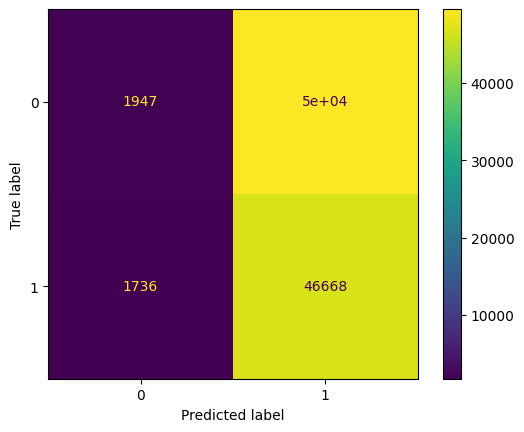

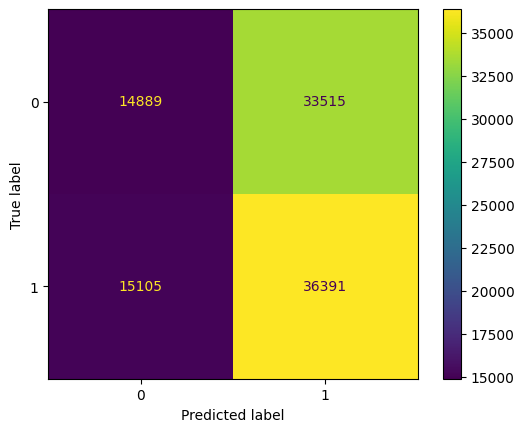

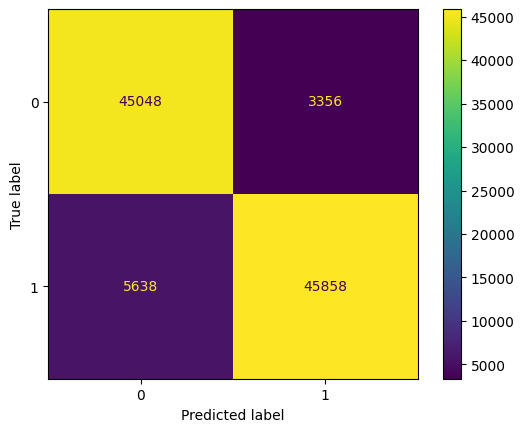

In [76]:
ConfusionMatrixDisplay(cm_).plot()
ConfusionMatrixDisplay(cm).plot()
ConfusionMatrixDisplay(cm_PUF).plot();